In [54]:
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Draw
IPythonConsole.molSize = (450,200)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
IPythonConsole.ipython_maxProperties = -1

In [2]:
df_combined = pd.read_csv('tmp_data/df_combined_298K_compact.csv')
df_combined = df_combined[df_combined.source != 'REACH']
df_combined

,standardized_smiles,log10_VP_Pa,inchikey,source
0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA
1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA
2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA
3,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA
4,O=C(O)c1cccc(Cl)c1Cl,-1.517198,QAOJBHRZQQDFHA-UHFFFAOYSA-N,OPERA
...,...,...,...,...
4434,CF,6.582000,NBVXSUQYWXRMNV-UHFFFAOYSA-N,Naef_Acree
4435,C#C,6.591000,HSFWRNGVRCDJHI-UHFFFAOYSA-N,Naef_Acree
4436,FC(F)F,6.672000,XPDWGBQVDMORPB-UHFFFAOYSA-N,Naef_Acree
4437,C,7.790000,VNWKTOKETHGBQD-UHFFFAOYSA-N,Naef_Acree


## Issue one: wrong mols in OPERA based on CAS

959-98-8 not the same
O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl
O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl|O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl|O=S1OC[C@H]2[C@@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@]2(Cl)C1(Cl)Cl
----
763-29-1 not the same
CCCC(C)=C
CCCCC(C)=C
----
2438-04-2 not the same
CC(C)C1C=CC=CC=1C(O)=O
CC(C)OC(=O)c1ccccc1
----
21981-48-6 not the same
CCCC(C)O[N+]([O-])=O
CC(C)CCO[N+]([O-])=O
----
541-88-8 not the same
O=C(CCl)OC(=O)CCl
CC1(C)/C(=C\C=C2/CCC(C=CC3=[N+](CCCS([O-])(=O)=O)c4ccc5ccccc5c4C3(C)C)=C/2N2CCN(CC2)C(=O)OCC)/N(CCCS(O)(=O)=O)c2ccc3ccccc3c12.CCN(CC)CC
----
1538-75-6 not the same
CC(C)(C)C(=O)OC(=O)C(C)(C)C
[Pr+3].CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C.CC(C)(C)C(=O)[CH-]C(=O)C(C)(C)C
----
4101-68-2 not the same
BrCCCCCCCCCCBr
CCCCCCCCC(Br)CBr
----
19398-53-9 not the same
CC(Br)CC(C)Br
CCCC(Br)CBr
----


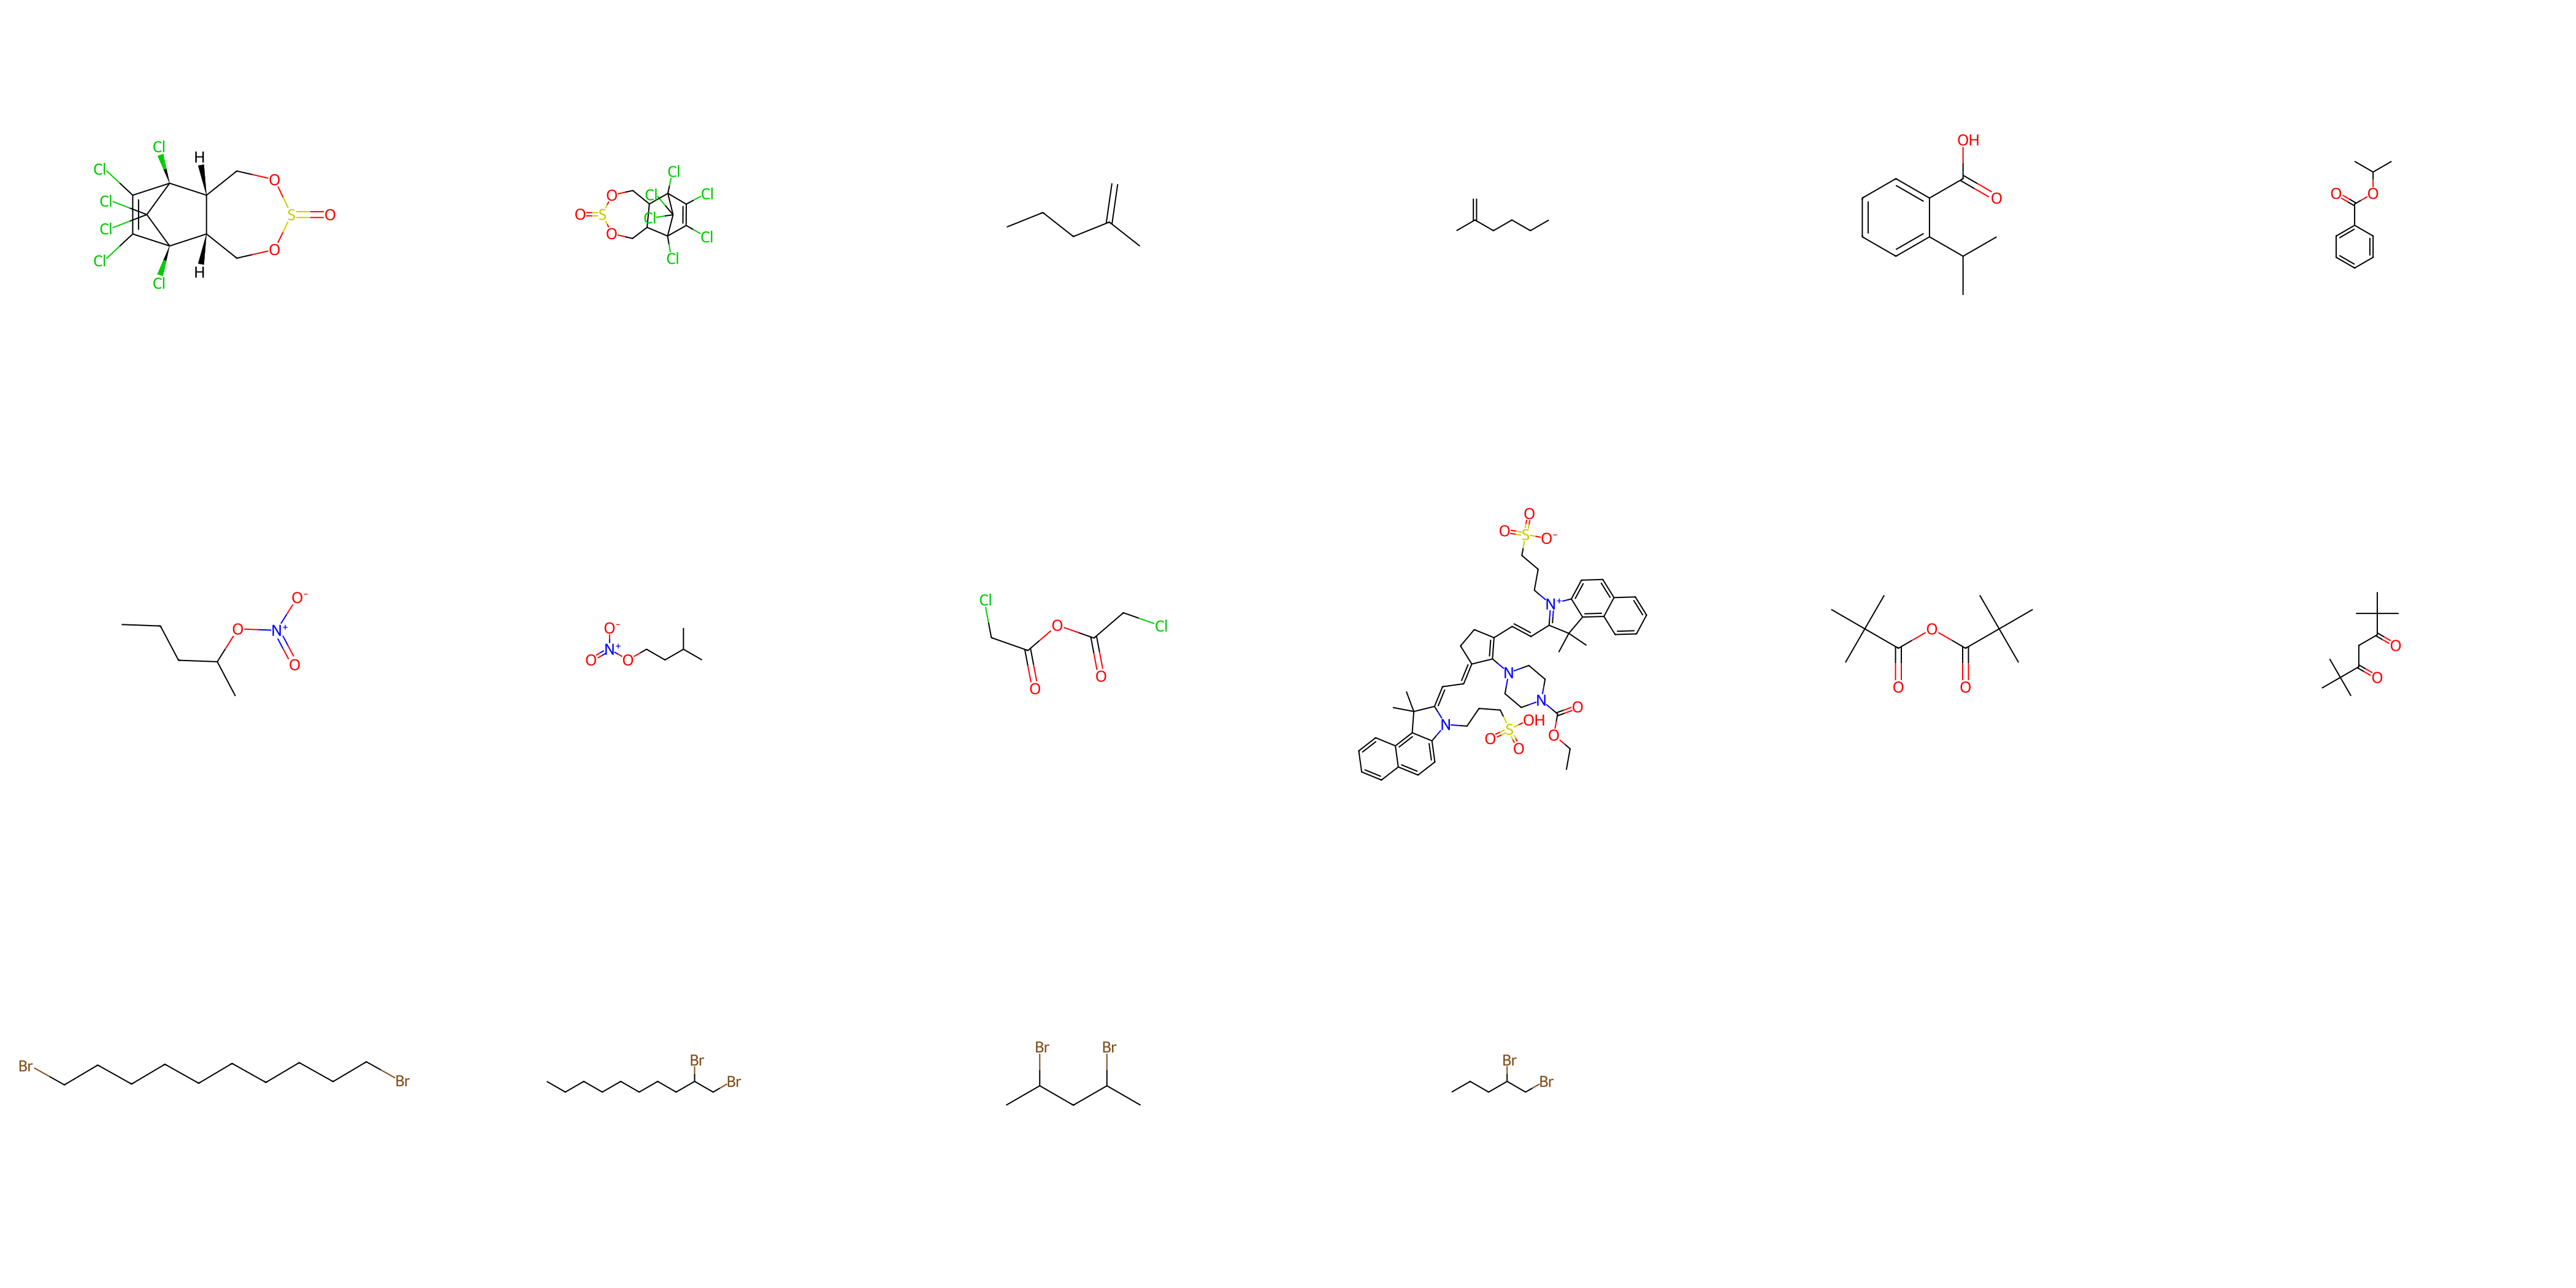

In [3]:
# Set the SDF file path
sdf_path = '/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_QR.sdf'

# Read molecules from the SDF file
mols_opera = Chem.SDMolSupplier(sdf_path)

# Read the CSV file
df_vp_update = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/OPERA_Data/VP_2.9_update.csv')

# Extract properties from molecules
OPERA_cas = [mol.GetProp('CAS') for mol in mols_opera]
OPERA_source_casrn = [mol.GetProp('source_casrn') for mol in mols_opera]
Original_SMILES = [mol.GetProp('Original_SMILES') for mol in mols_opera]

# Filter non-matching CAS
df_OPREA_cas_not_same = pd.DataFrame({'CAS': OPERA_cas, 'source_casrn': OPERA_source_casrn, 'Original_SMILES': Original_SMILES})
df_OPREA_cas_not_same = df_OPREA_cas_not_same[df_OPREA_cas_not_same['source_casrn'] != df_OPREA_cas_not_same['CAS'] + '|?']

# Drop rows with CAS containing '|'
indeces_to_drop = [i for i, (cas, source_casrn) in enumerate(zip(df_OPREA_cas_not_same['CAS'], df_OPREA_cas_not_same['source_casrn'])) if '|' in cas and len(set(cas.split('|')).intersection(set(source_casrn.split('|')))) > 0]
df_OPREA_cas_not_same = df_OPREA_cas_not_same[~df_OPREA_cas_not_same.index.isin(indeces_to_drop)]

# Find non-matching SMILES between CSV and SDF
non_matching_smiles_df_update = []
non_matching_smiles_sdf = []
cas_from_sdf_to_edit = []
smiles_to_edit_from, smiles_to_edit_to = [], []

for cas, smi in zip(df_OPREA_cas_not_same['source_casrn'], df_OPREA_cas_not_same['Original_SMILES']):
    cas_split = cas.split('|')
    for c in cas_split:
        try:
            smiles_in_df = df_vp_update[df_vp_update['CASRN'] == c]['Original_SMILES'].iloc[0]
        except IndexError:
            continue
        if smiles_in_df != smi:
            print(f'{c} not the same')
            cas_from_sdf_to_edit.append(c)
            print(smiles_in_df)
            print(smi)
            print('----')
            non_matching_smiles_df_update.append(smiles_in_df)
            non_matching_smiles_sdf.append(smi)
            smiles_to_edit_from.append(smi)
            smiles_to_edit_to.append(smiles_in_df)

# Create standardized molecules
mols_df = [Chem.MolFromSmiles(smi) for smi in non_matching_smiles_df_update]
mols_sdf = [mol for mol in mols_opera if mol.GetProp('Original_SMILES') in non_matching_smiles_sdf]
mols_combined = []
for mol_df, mol_sdf in zip(mols_df, mols_sdf):
    if mol_df is None or mol_sdf is None:
        continue
    mols_combined.append(mol_df)
    mols_combined.append(mol_sdf)
# Display the molecules in a grid image
img = Draw.MolsToGridImage(mols_combined, molsPerRow=6, subImgSize=(700, 700))
img

In [4]:
mols_combined_standardized = [rdMolStandardize.ChargeParent(mol) for mol in mols_combined]
sdf_mols_standardized = mols_combined_standardized[1::2]
df_mols_standardized = mols_combined_standardized[::2]
wrong_mols_smiles = [Chem.MolToSmiles(smi) for smi in sdf_mols_standardized]
right_mols_smiles = [Chem.MolToSmiles(smi) for smi in df_mols_standardized]
df_combined[df_combined['standardized_smiles'].isin(wrong_mols_smiles)]

[13:30:15] Initializing MetalDisconnector
[13:30:15] Running MetalDisconnector
[13:30:15] Initializing Normalizer
[13:30:15] Running Normalizer
[13:30:15] Running LargestFragmentChooser
[13:30:15] Fragment: O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl
[13:30:15] New largest fragment: O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@@]2(Cl)C1(Cl)Cl (25)
[13:30:15] Running Uncharger
[13:30:15] Initializing MetalDisconnector
[13:30:15] Running MetalDisconnector
[13:30:15] Initializing Normalizer
[13:30:15] Running Normalizer
[13:30:15] Initializing MetalDisconnector
[13:30:15] Running MetalDisconnector
[13:30:15] Initializing Normalizer
[13:30:15] Running Normalizer
[13:30:15] Running LargestFragmentChooser
[13:30:15] Fragment: O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl
[13:30:15] New largest fragment: O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl (25)
[13:30:15] Running Uncharger
[13:30:15] Initializing MetalDisconnector
[13:30:15] Running MetalDisconnector
[13:30:15] In

,standardized_smiles,log10_VP_Pa,inchikey,source
810,O=S1OCC2C(CO1)C1(Cl)C(Cl)=C(Cl)C2(Cl)C1(Cl)Cl,-4.637097,RDYMFSUJUZBWLH-UHFFFAOYSA-N,OPERA
1562,C=C(C)CCCC,4.162301,IRUDSQHLKGNCGF-UHFFFAOYSA-N,OPERA
1806,CC(C)OC(=O)c1ccccc1,-1.334398,FEXQDZTYJVXMOS-UHFFFAOYSA-N,OPERA
2022,CC(C)CCO[N+](=O)[O-],2.835002,NTHGIYFSMNNHSC-UHFFFAOYSA-N,OPERA
2318,CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O...,0.695302,ZVTSEGXUAUCYQH-UHFFFAOYSA-N,OPERA
2332,CC(C)(C)C(=O)CC(=O)C(C)(C)C,1.768402,YRAJNWYBUCUFBD-UHFFFAOYSA-N,OPERA
2337,CCCCCCCCC(Br)CBr,-0.303999,XBRBOTTWTQOCJH-UHFFFAOYSA-N,OPERA
2350,CCCC(Br)CBr,2.278403,CITMYAPULDSOHG-UHFFFAOYSA-N,OPERA
4052,C=C(C)CCCC,3.909000,IRUDSQHLKGNCGF-UHFFFAOYSA-N,Naef_Acree


In [5]:
df_combined[df_combined['standardized_smiles'].isin(right_mols_smiles)]

,standardized_smiles,log10_VP_Pa,inchikey,source
4206,C=C(C)CCC,4.406,WWUVJRULCWHUSA-UHFFFAOYSA-N,Naef_Acree


In [6]:
df_combined.loc[(df_combined['source'] == 'OPERA') & (df_combined['standardized_smiles'].isin(wrong_mols_smiles)), 'standardized_smiles'] = right_mols_smiles
df_combined[df_combined['standardized_smiles'].isin(right_mols_smiles)]

,standardized_smiles,log10_VP_Pa,inchikey,source
810,O=S1OC[C@@H]2[C@H](CO1)[C@]1(Cl)C(Cl)=C(Cl)[C@...,-4.637097,RDYMFSUJUZBWLH-UHFFFAOYSA-N,OPERA
1562,C=C(C)CCC,4.162301,IRUDSQHLKGNCGF-UHFFFAOYSA-N,OPERA
1806,CC(C)c1ccccc1C(=O)O,-1.334398,FEXQDZTYJVXMOS-UHFFFAOYSA-N,OPERA
2022,CCCC(C)O[N+](=O)[O-],2.835002,NTHGIYFSMNNHSC-UHFFFAOYSA-N,OPERA
2318,O=C(CCl)OC(=O)CCl,0.695302,ZVTSEGXUAUCYQH-UHFFFAOYSA-N,OPERA
2332,CC(C)(C)C(=O)OC(=O)C(C)(C)C,1.768402,YRAJNWYBUCUFBD-UHFFFAOYSA-N,OPERA
2337,BrCCCCCCCCCCBr,-0.303999,XBRBOTTWTQOCJH-UHFFFAOYSA-N,OPERA
2350,CC(Br)CC(C)Br,2.278403,CITMYAPULDSOHG-UHFFFAOYSA-N,OPERA
4206,C=C(C)CCC,4.406000,WWUVJRULCWHUSA-UHFFFAOYSA-N,Naef_Acree


In [7]:
df_combined[df_combined['inchikey'] == 'WQZGKKKJIJFFOK-UHFFFAOYSA-N']


,standardized_smiles,log10_VP_Pa,inchikey,source
1126,OCC1OC(O)C(O)C(O)C1O,-10.970898,WQZGKKKJIJFFOK-UHFFFAOYSA-N,OPERA


In [9]:
mols_oja_suuberg = [mol for mol in mols_opera if mol.GetProp('VP Reference') == 'OJA,V & SUUBERG (1999)']
standardized_smiles_oja_suuberg = [Chem.MolToSmiles(rdMolStandardize.ChargeParent(mol)) for mol in mols_oja_suuberg]
df_combined[df_combined['standardized_smiles'].isin(standardized_smiles_oja_suuberg)]

[13:32:18] Initializing MetalDisconnector
[13:32:18] Running MetalDisconnector
[13:32:18] Initializing Normalizer
[13:32:18] Running Normalizer
[13:32:18] Running LargestFragmentChooser
[13:32:18] Fragment: O=CC(O)C(O)C(O)CO
[13:32:18] New largest fragment: O=CC(O)C(O)C(O)CO (20)
[13:32:18] Running Uncharger
[13:32:18] Initializing MetalDisconnector
[13:32:18] Running MetalDisconnector
[13:32:18] Initializing Normalizer
[13:32:18] Running Normalizer
[13:32:18] Initializing MetalDisconnector
[13:32:18] Running MetalDisconnector
[13:32:18] Initializing Normalizer
[13:32:18] Running Normalizer
[13:32:18] Running LargestFragmentChooser
[13:32:18] Fragment: OCC1OC(O)C(O)C(O)C1O
[13:32:18] New largest fragment: OCC1OC(O)C(O)C(O)C1O (24)
[13:32:18] Running Uncharger
[13:32:18] Initializing MetalDisconnector
[13:32:18] Running MetalDisconnector
[13:32:18] Initializing Normalizer
[13:32:18] Running Normalizer
[13:32:18] Initializing MetalDisconnector
[13:32:18] Running MetalDisconnector
[13:32:

,standardized_smiles,log10_VP_Pa,inchikey,source
25,O=CC(O)C(O)C(O)CO,-7.580599,PYMYPHUHKUWMLA-UHFFFAOYSA-N,OPERA
1126,OCC1OC(O)C(O)C(O)C1O,-10.970898,WQZGKKKJIJFFOK-UHFFFAOYSA-N,OPERA
2317,OC1C2COC(O2)C(O)C1O,-4.999998,TWNIBLMWSKIRAT-UHFFFAOYSA-N,OPERA


In [10]:
df_combined = df_combined[~df_combined['standardized_smiles'].isin(standardized_smiles_oja_suuberg)]


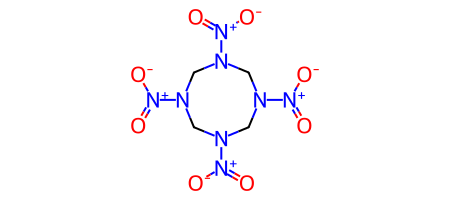

In [11]:
HMX_mol = [mol for mol in mols_opera if mol.GetProp('preferred_name') == 'Cyclotetramethylenetetranitramine'][0]
HMX_mol

In [13]:
#recent paper: Vapor Pressures of RDX and HMX Explosives Measured at and Near Room Temperature: 1,3,5-Trinitro-1,3,5-triazinane and 1,3,5,7-Tetranitro-1,3,5,7-tetrazocane
#set the vapor pressure of HMX to 1.5e-15 atm
vp_atm = 1.5e-15
vp_pascal = vp_atm * 101325
import numpy as np
vp_log10_pa = np.log10(vp_pascal)
print(vp_log10_pa)
#change the vapor pressure of HMX in the dataframe
df_combined[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol)]

-9.818192128530589


,standardized_smiles,log10_VP_Pa,inchikey,source
1834,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,-11.356599,UZGLIIJVICEWHF-UHFFFAOYSA-N,OPERA


In [14]:
df_combined.loc[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol), 'log10_VP_Pa'] = vp_log10_pa
df_combined[df_combined['standardized_smiles'] == Chem.MolToSmiles(HMX_mol)]

,standardized_smiles,log10_VP_Pa,inchikey,source
1834,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])...,-9.818192,UZGLIIJVICEWHF-UHFFFAOYSA-N,OPERA


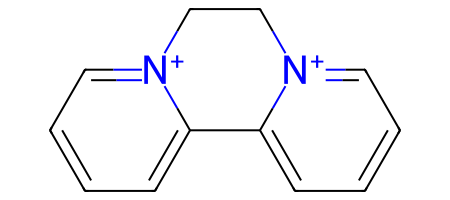

In [15]:
diquat_mol = [mol for mol in mols_opera if mol.GetProp('preferred_name') == 'Diquat'][0]
diquat_mol

In [16]:
##crossval with this df
df_combined

,standardized_smiles,log10_VP_Pa,inchikey,source
0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA
1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA
2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA
3,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA
4,O=C(O)c1cccc(Cl)c1Cl,-1.517198,QAOJBHRZQQDFHA-UHFFFAOYSA-N,OPERA
...,...,...,...,...
4434,CF,6.582000,NBVXSUQYWXRMNV-UHFFFAOYSA-N,Naef_Acree
4435,C#C,6.591000,HSFWRNGVRCDJHI-UHFFFAOYSA-N,Naef_Acree
4436,FC(F)F,6.672000,XPDWGBQVDMORPB-UHFFFAOYSA-N,Naef_Acree
4437,C,7.790000,VNWKTOKETHGBQD-UHFFFAOYSA-N,Naef_Acree


In [102]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.preprocessing import StandardScaler
def train_grouped_kfold(df,params,descriptors,name='test',split_on = 'molregno',y='vp_log10pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X = df[split_on].to_numpy()
    output = ([],[],[],[],[],[],[],[],[],[],[])
    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        train_all = df[df[split_on].isin(X[train_index])]
        test_all = df[df[split_on].isin(X[test_index])]

        train_X = train_all[descriptors]
        train_y = train_all[y]
        test_X = test_all[descriptors]
        test_y = test_all[y]
        molregnos_test = test_all[split_on]

        if normalize_x:
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X)
            test_X = scaler.transform(test_X)

        dtrain = xgb.DMatrix(train_X, label=train_y)
        dtest = xgb.DMatrix(test_X, label=test_y)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=999,
            verbose_eval=False
        )

        preds = model.predict(dtest)
        output[0].append(test_y.to_list())
        output[1].append(list(preds))
        output[2].append(molregnos_test.to_list())


        #print the RMSEs
        rmse = mean_squared_error(test_y, preds, squared=False)
        print(f"Fold {i + 1}: RMSE = {rmse}")

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(output, f)

    return output

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_single_custom_local(reals, predictions, molregnos, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    rmses, maes, ebos, kts,median_aes = [], [], [], [],[]
    
    for r, p in zip(reals, predictions):
        RMSE, MAE, EBO, KT,median_AE = getStatValues_v2(r, p)
        rmses.append(RMSE)
        maes.append(MAE)
        ebos.append(EBO)
        kts.append(KT)
        median_aes.append(median_AE)
    
    rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
    rmse_mean = np.mean(rmses)
    mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
    mae_mean = np.mean(maes)
    ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
    ebo_mean = np.mean(ebos)
    kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
    kt_mean = np.mean(kts)
    median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
    median_AE_mean = np.mean(median_aes)

    
    # molregno = molregnos[0]
    
    mrn = [item for sublist in molregnos for item in sublist]
    real = [item for sublist in reals for item in sublist]
    prediction = [item for sublist in predictions for item in sublist]
    
    df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
    df = df.groupby('molregno').mean()
    real = df['real'].tolist()
    prediction = df['prediction'].tolist()
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
    
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

In [43]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    #add inchikey
    res['inchikey'] = Chem.MolToInchiKey(mol)
    return res

mols = [Chem.MolFromSmiles(smi) for smi in df_combined['standardized_smiles']]
descriptors = [getMolDescriptors(m) for m in mols]
descriptor_df = pd.DataFrame(descriptors)
df_combined_descritptors = df_combined.merge(descriptor_df, on='inchikey')
df_combined_descritptors = df_combined_descritptors.drop_duplicates()
df_combined_descritptors

[13:55:54] unrecognized chirality tag (8) on atom 6 is ignored.
[13:55:54] unrecognized chirality tag (8) on atom 17 is ignored.
[13:55:55] unrecognized chirality tag (8) on atom 4 is ignored.
[13:55:55] unrecognized chirality tag (8) on atom 11 is ignored.
[13:55:55] unrecognized chirality tag (8) on atom 1 is ignored.
[13:55:55] unrecognized chirality tag (8) on atom 7 is ignored.
[13:55:55] unrecognized chirality tag (8) on atom 13 is ignored.
[13:55:56] unrecognized chirality tag (8) on atom 3 is ignored.
[13:55:56] unrecognized chirality tag (8) on atom 11 is ignored.
[13:55:56] unrecognized chirality tag (8) on atom 9 is ignored.
[13:55:56] unrecognized chirality tag (8) on atom 6 is ignored.
[13:55:56] unrecognized chirality tag (8) on atom 5 is ignored.
[13:55:57] unrecognized chirality tag (8) on atom 6 is ignored.


,standardized_smiles,log10_VP_Pa,inchikey,source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA,9.449074,9.449074,1.185185,-1.231481,0.453936,90.078,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA,10.567284,10.567284,0.030864,-1.187500,0.744344,225.458,...,0,0,0,0,0,0,0,0,0,0
2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA,2.309074,2.309074,1.317945,1.317945,0.243454,252.316,...,0,0,0,0,0,0,0,0,0,0
4,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135000,FMMWHPNWAFZXNH-UHFFFAOYSA-N,Naef_Acree,2.309074,2.309074,1.317945,1.317945,0.243454,252.316,...,0,0,0,0,0,0,0,0,0,0
6,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA,12.296709,12.296709,0.097012,-0.408467,0.797936,303.358,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,FC(F)Br,5.639000,GRCDJFHYVYUNHM-UHFFFAOYSA-N,Naef_Acree,10.250000,10.250000,1.937500,-2.354167,0.437677,130.919,...,0,0,0,0,0,0,0,0,0,0
6428,F/C=C/C(F)(F)F,5.698000,CDOOAUSHHFGWSA-OWOJBTEDSA-N,Naef_Acree,10.729167,10.729167,0.479167,-4.505208,0.422449,114.041,...,0,0,0,0,0,0,0,0,0,0
6429,C=O,5.710000,WSFSSNUMVMOOMR-UHFFFAOYSA-N,Naef_Acree,8.000000,8.000000,2.000000,2.000000,0.360624,30.026,...,0,0,0,0,0,0,0,0,0,0
6430,FC(F)(F)OO[S@OH5](F)(F)(F)(F)F,5.821000,QYSKJQVQYGRSJM-UHFFFAOYSA-N,Naef_Acree,10.898472,10.898472,1.128472,-10.594807,0.407488,228.060,...,0,0,0,0,0,0,0,0,0,0


In [104]:
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
outputs_combined = train_grouped_kfold(df_combined_descritptors,params,RDKit_feature_names,name='outputs_combined_no_duplicates',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=False)

Fold 1: RMSE = 0.5707799188502383
Fold 2: RMSE = 0.6170238682288333
Fold 3: RMSE = 0.5968867812670656
Fold 4: RMSE = 0.6226446599791657
Fold 5: RMSE = 0.626257154035002
Fold 6: RMSE = 0.629870886456428
Fold 7: RMSE = 0.5905376946519311
Fold 8: RMSE = 0.630455371069286
Fold 9: RMSE = 0.5538353124773753
Fold 10: RMSE = 0.6373272069505346
Fold 11: RMSE = 0.5854571160020939
Fold 12: RMSE = 0.5947648636102874
Fold 13: RMSE = 0.6241154908195463
Fold 14: RMSE = 0.5697543368529826
Fold 15: RMSE = 0.594220467057343


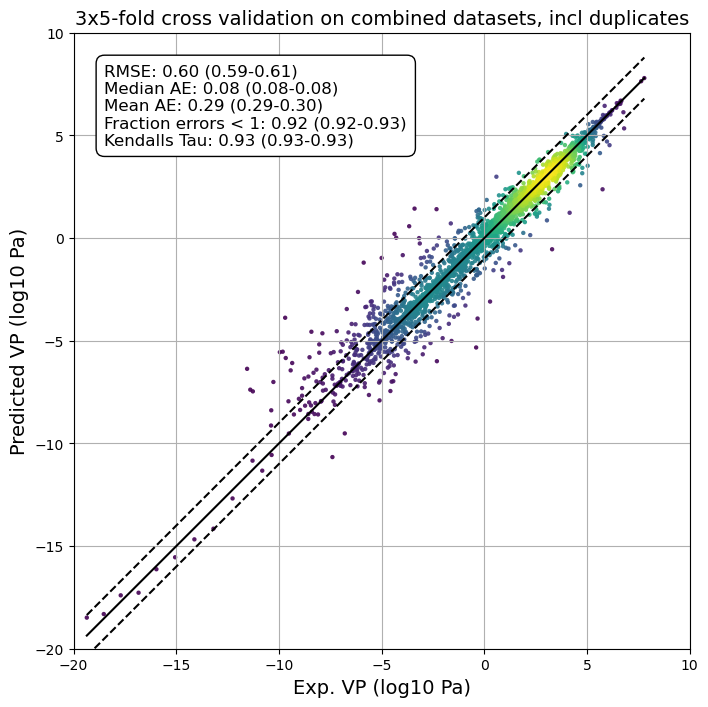

In [110]:
density_plot_single_custom_local(reals = outputs_combined[0], predictions = outputs_combined[1], bounds=[-20,10], molregnos=outputs_combined[2], title='3x5-fold cross validation on combined datasets, incl duplicates')

6.680627845194822


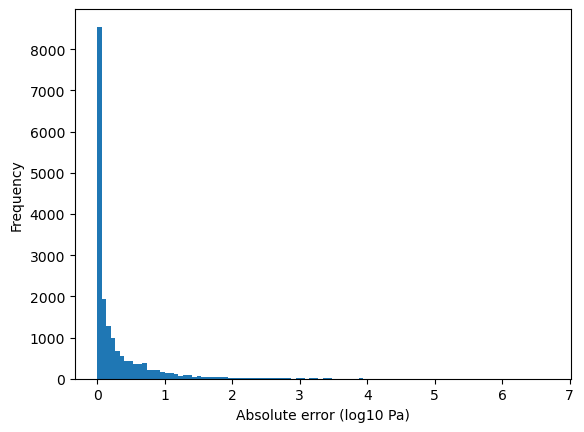

In [108]:
abs_errors_list = []
for reals,preds in zip(outputs_combined[0],outputs_combined[1]):
    abs_errors = np.abs(np.array(reals) - np.array(preds))
    abs_errors_list.extend(abs_errors)
print(max(abs_errors_list))
plt.hist(abs_errors_list, bins=100)
plt.xlabel('Absolute error (log10 Pa)')
plt.ylabel('Frequency')
plt.show()



In [47]:
#make df of reals, preds, inchikeys, molregnos
reals = outputs_combined[0]
preds = outputs_combined[1]
inchikeys = outputs_combined[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
inchikeys_flat = [item for sublist in inchikeys for item in sublist]
df_CV_new_set = pd.DataFrame({'reals': reals_flat, 'preds': preds_flat, 'inchikey': inchikeys_flat})
df_CV_new_set = df_CV_new_set.groupby('inchikey').mean()
df_CV_new_set['abs_error'] = np.abs(df_CV_new_set['reals']-df_CV_new_set['preds'])
df_CV_new_set.sort_values(by=['abs_error'],ascending=False,inplace=True)
#print number of datapoints with error > 1, 2, 3
print(len(df_CV_new_set[df_CV_new_set['abs_error']>1]), ' datapoints with error > 1')
print(len(df_CV_new_set[df_CV_new_set['abs_error']>2]), ' datapoints with error > 2')
print(len(df_CV_new_set[df_CV_new_set['abs_error']>3]), ' datapoints with error > 3')
df_CV_new_set

335  datapoints with error > 1
90  datapoints with error > 2
30  datapoints with error > 3


,reals,preds,abs_error
inchikey,,,
KCXVZYZYPLLWCC-UHFFFAOYSA-N,-9.698998,-3.881146,5.817852
XMQFTWRPUQYINF-UHFFFAOYSA-N,-11.552897,-6.368315,5.184582
YLTPZAWSNFUXES-ROUUACIJSA-N,-0.398000,-5.329370,4.931370
QAYICIQNSGETAS-UHFFFAOYSA-N,-3.398000,1.433933,4.831933
SYJFEGQWDCRVNX-UHFFFAOYSA-N,-5.875098,-1.196738,4.678360
...,...,...,...
FGLBSLMDCBOPQK-UHFFFAOYSA-N,3.355749,3.355756,0.000007
KDKYADYSIPSCCQ-UHFFFAOYSA-N,5.275151,5.275146,0.000005
VXNZUUAINFGPBY-UHFFFAOYSA-N,5.353551,5.353548,0.000003


In [84]:
from rdkit.Chem import Draw
df_CV_new_set_error_over_2 = df_CV_new_set[df_CV_new_set['abs_error'] > 2]
df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)
df_CV_new_set_error_over_2
inchis_error_sorted = df_CV_new_set_error_over_2.index.to_list()
preds = df_CV_new_set_error_over_2['preds'].to_list()
sources, ground_truths, smiles = [], [], []
pred_list,inchikey_list = [],[]
for inchikey,pred in zip(inchis_error_sorted,preds):
    df_subset = df_combined[df_combined['inchikey']==inchikey]
    sources.extend(df_subset['source'].to_list())
    ground_truths.extend(df_subset['log10_VP_Pa'].to_list())
    smiles.extend(df_subset['standardized_smiles'].to_list())
    inchikey_list.extend(df_subset['inchikey'].to_list())
    pred_list.extend([pred]*len(df_subset))
df_to_check = pd.DataFrame({'source':sources,'ground_truth':ground_truths,'smiles':smiles,'preds':pred_list,'inchikey':inchikey_list})
df_to_check
#draw first 10 with ground_truth, pred, source
df_to_check_subset = df_to_check.iloc[:10]
mols = [Chem.MolFromSmiles(smi) for smi in df_to_check_subset['smiles']]
ground_truths = df_to_check_subset['ground_truth'].to_list()
preds = df_to_check_subset['preds'].to_list()
sources = df_to_check_subset['source'].to_list()
# img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(700, 700), legends=[f'ground_truth: {round(ground_truth,2)}\npred: {round(pred,2)}\nsource: {source}' for ground_truth,pred,source in zip(ground_truths,preds,sources)])
# img


/tmp/ipykernel_1918573/3202268038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CV_new_set_error_over_2.sort_values(by=['abs_error'],ascending=False,inplace=True)


In [52]:
opera_error_mols_with_info = []
for op_mol in mols_opera:
     op_mol = rdMolStandardize.ChargeParent(op_mol)
     op_mol_inchikey = Chem.MolToInchiKey(op_mol)
     for m in mols:
          m_inchikey = Chem.MolToInchiKey(m)
          if m_inchikey == op_mol_inchikey:
               opera_error_mols_with_info.append(op_mol)
               break

[14:05:41] Initializing MetalDisconnector
[14:05:41] Running MetalDisconnector
[14:05:41] Initializing Normalizer
[14:05:41] Running Normalizer
[14:05:41] Running LargestFragmentChooser
[14:05:41] Fragment: CC(O)C(=O)O
[14:05:41] New largest fragment: CC(O)C(=O)O (12)
[14:05:41] Running Uncharger
[14:05:41] Initializing MetalDisconnector
[14:05:41] Running MetalDisconnector
[14:05:41] Initializing Normalizer
[14:05:41] Running Normalizer
[14:05:41] Initializing MetalDisconnector
[14:05:41] Running MetalDisconnector
[14:05:41] Initializing Normalizer
[14:05:41] Running Normalizer
[14:05:41] Running LargestFragmentChooser
[14:05:41] Fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
[14:05:41] New largest fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1 (28)
[14:05:41] Running Uncharger
[14:05:41] Initializing MetalDisconnector
[14:05:41] Running MetalDisconnector
[14:05:41] Initializing Normalizer
[14:05:41] Running Normalizer
[14:05:41] Initializing MetalDisconnector
[14:05:41] Running M

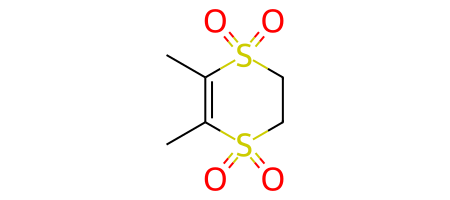

In [86]:
#confflicting data from EPA and ARS pesticide databse, remove!
np.log10(0.051*1000),np.log10((3.81*10**-7)*133.322)
opera_error_mols_with_info[6]

In [87]:
df_to_check_subset = df_to_check.iloc[10:20]
mols = [Chem.MolFromSmiles(smi) for smi in df_to_check_subset['smiles']]
opera_error_mols_with_info = []
for op_mol in mols_opera:
     op_mol = rdMolStandardize.ChargeParent(op_mol)
     op_mol_inchikey = Chem.MolToInchiKey(op_mol)
     for m in mols:
          m_inchikey = Chem.MolToInchiKey(m)
          if m_inchikey == op_mol_inchikey:
               opera_error_mols_with_info.append(op_mol)
               break

[15:13:16] Initializing MetalDisconnector
[15:13:16] Running MetalDisconnector
[15:13:16] Initializing Normalizer
[15:13:16] Running Normalizer
[15:13:16] Running LargestFragmentChooser
[15:13:16] Fragment: CC(O)C(=O)O
[15:13:16] New largest fragment: CC(O)C(=O)O (12)
[15:13:16] Running Uncharger
[15:13:16] Initializing MetalDisconnector
[15:13:16] Running MetalDisconnector
[15:13:16] Initializing Normalizer
[15:13:16] Running Normalizer
[15:13:16] Initializing MetalDisconnector
[15:13:16] Running MetalDisconnector
[15:13:16] Initializing Normalizer
[15:13:16] Running Normalizer
[15:13:16] Running LargestFragmentChooser
[15:13:16] Fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1
[15:13:16] New largest fragment: Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1 (28)
[15:13:16] Running Uncharger
[15:13:16] Initializing MetalDisconnector
[15:13:16] Running MetalDisconnector
[15:13:16] Initializing Normalizer
[15:13:16] Running Normalizer
[15:13:16] Initializing MetalDisconnector
[15:13:16] Running M

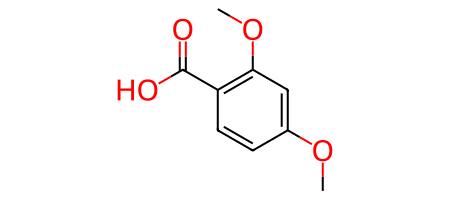

In [101]:
opera_error_mols_with_info[1]

In [111]:
df_combined

,standardized_smiles,log10_VP_Pa,inchikey,source
0,CC(O)C(=O)O,1.035002,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,OPERA
1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-1.134698,XZIDTOHMJBOSOX-UHFFFAOYSA-N,OPERA
2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-6.135498,FMMWHPNWAFZXNH-UHFFFAOYSA-N,OPERA
3,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-4.594099,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,OPERA
4,O=C(O)c1cccc(Cl)c1Cl,-1.517198,QAOJBHRZQQDFHA-UHFFFAOYSA-N,OPERA
...,...,...,...,...
4434,CF,6.582000,NBVXSUQYWXRMNV-UHFFFAOYSA-N,Naef_Acree
4435,C#C,6.591000,HSFWRNGVRCDJHI-UHFFFAOYSA-N,Naef_Acree
4436,FC(F)F,6.672000,XPDWGBQVDMORPB-UHFFFAOYSA-N,Naef_Acree
4437,C,7.790000,VNWKTOKETHGBQD-UHFFFAOYSA-N,Naef_Acree


## Overlap values Naef & Acree and OPERA

In [120]:
df1 = df_combined[df_combined['source']=='OPERA']
df2 = df_combined[df_combined['source']=='Naef_Acree']
#get overlapping inchikeys
inchikeys_source1 = df1['inchikey'].unique()
inchikeys_source2 = df2['inchikey'].unique()
inchikeys_overlap = list(set(inchikeys_source1).intersection(inchikeys_source2))
#get duplicates
df1_duplicates = df1[df1['inchikey'].isin(inchikeys_overlap)]
df2_duplicates = df2[df2['inchikey'].isin(inchikeys_overlap)]
#drop duplicates
df1_duplicates = df1_duplicates.drop_duplicates(subset=['inchikey'])
df2_duplicates = df2_duplicates.drop_duplicates(subset=['inchikey'])
#sort by inchikey
df_subset_duplicates_source1 = df1_duplicates.sort_values(by=['inchikey'])
df_subset_duplicates_source2 = df2_duplicates.sort_values(by=['inchikey'])
vals_1 = df_subset_duplicates_source1['log10_VP_Pa'].values
vals_2 = df_subset_duplicates_source2['log10_VP_Pa'].values
inchikeys_overlap = df_subset_duplicates_source1['inchikey'].values
diff = vals_1-vals_2
diff_abs = np.abs(diff)
number_larger_2 = len(diff_abs[diff_abs>2])
print(number_larger_2, ' datapoints with error > 2')
#make df of vals_1, vals_2, inchikeys
df_to_check = pd.DataFrame({'OPERA':vals_1,'Naef_Acree':vals_2,'inchikey':inchikeys_overlap})
df_to_check['abs_diff'] = np.abs(df_to_check['OPERA']-df_to_check['Naef_Acree'])
df_to_check.sort_values(by=['abs_diff'],ascending=False,inplace=True)
df_to_check.head(19)

19  datapoints with error > 2


,OPERA,Naef_Acree,inchikey,abs_diff
810,-8.522898,-3.213,VJYIFXVZLXQVHO-UHFFFAOYSA-N,5.309898
559,-6.875098,-1.959,OVSKIKFHRZPJSS-UHFFFAOYSA-N,4.916098
71,-1.043198,2.095,BTGRAWJCKBQKAO-UHFFFAOYSA-N,3.138198
215,0.787702,3.706,GNOIPBMMFNIUFM-UHFFFAOYSA-N,2.918298
185,-9.958598,-7.180,FOIBFBMSLDGNHL-UHFFFAOYSA-N,2.778598
658,-9.301098,-6.585,RHIROFAGUQOFLU-UHFFFAOYSA-N,2.716098
839,-8.327298,-5.714,WDMKCPIVJOGHBF-UHFFFAOYSA-N,2.613298
836,-8.291898,-5.839,WCYYQNSQJHPVMG-UHFFFAOYSA-N,2.452898
15,-5.251899,-2.876,AMEKQAFGQBKLKX-UHFFFAOYSA-N,2.375899
838,-6.080598,-3.750,WDECIBYCCFPHNR-UHFFFAOYSA-N,2.330598


In [131]:
# df_combined_overlap = df_combined[df_combined['inchikey'].isin(df_to_check['inchikey'].head(19).values)]
# smiles = df_combined_overlap['standardized_smiles'].tolist()
# Draw.MolsToGridImage(mols = [Chem.MolFromSmiles(smi) for smi in smiles], molsPerRow=4, subImgSize=(700, 700))

In [124]:
df_combined[df_combined['inchikey']=='VJYIFXVZLXQVHO-UHFFFAOYSA-N']
Chem.MolFromSmiles('COc1nc(C)nc(NC(=O)NS(=O)(=O)c2ccccc2Cl)n1')
print('Literature val: ', np.log10(3*10**-9)) #https://doi.org/10.1002/(SICI)1526-4998(200006)56:6<521::AID-PS155>3.0.CO;2-Y

Literature val:  -8.522878745280337


In [140]:
df_combined[df_combined['inchikey']=='OVSKIKFHRZPJSS-UHFFFAOYSA-N']
Chem.MolFromSmiles('O=C(O)COc1ccc(Cl)cc1Cl')
np.log10(1.40*10**-7 * 133.322),np.log10(1.9*10**-5) #from http://npic.orst.edu/factsheets/archive/2,4-DTech.html#references

(-4.728970144313402, -4.721246399047171)

In [144]:
print(np.log10(133*6.8*10**-4))
df_combined[df_combined['inchikey']=='BTGRAWJCKBQKAO-UHFFFAOYSA-N'] #nothing found. one paper with a value but no unit: https://pubs.acs.org/doi/epdf/10.1021/j100834a032


-1.0436394463266778


,standardized_smiles,log10_VP_Pa,inchikey,source
743,N#CCCCCC#N,-1.043198,BTGRAWJCKBQKAO-UHFFFAOYSA-N,OPERA
3476,N#CCCCCC#N,2.095000,BTGRAWJCKBQKAO-UHFFFAOYSA-N,Naef_Acree


In [147]:
print(np.log10(133*0.07),np.log10(133*0.046)) #https://pubchem.ncbi.nlm.nih.gov/compound/12679#section=Vapor-Density
df_combined[df_combined['inchikey']=='GNOIPBMMFNIUFM-UHFFFAOYSA-N'] 

0.9689496809813426 0.7866094726486599


,standardized_smiles,log10_VP_Pa,inchikey,source
1534,CN(C)P(=O)(N(C)C)N(C)C,0.787702,GNOIPBMMFNIUFM-UHFFFAOYSA-N,OPERA
3977,CN(C)P(=O)(N(C)C)N(C)C,3.706000,GNOIPBMMFNIUFM-UHFFFAOYSA-N,Naef_Acree


In [148]:
df_to_check.head(19)

,OPERA,Naef_Acree,inchikey,abs_diff
810,-8.522898,-3.213,VJYIFXVZLXQVHO-UHFFFAOYSA-N,5.309898
559,-6.875098,-1.959,OVSKIKFHRZPJSS-UHFFFAOYSA-N,4.916098
71,-1.043198,2.095,BTGRAWJCKBQKAO-UHFFFAOYSA-N,3.138198
215,0.787702,3.706,GNOIPBMMFNIUFM-UHFFFAOYSA-N,2.918298
185,-9.958598,-7.180,FOIBFBMSLDGNHL-UHFFFAOYSA-N,2.778598
658,-9.301098,-6.585,RHIROFAGUQOFLU-UHFFFAOYSA-N,2.716098
839,-8.327298,-5.714,WDMKCPIVJOGHBF-UHFFFAOYSA-N,2.613298
836,-8.291898,-5.839,WCYYQNSQJHPVMG-UHFFFAOYSA-N,2.452898
15,-5.251899,-2.876,AMEKQAFGQBKLKX-UHFFFAOYSA-N,2.375899
838,-6.080598,-3.750,WDECIBYCCFPHNR-UHFFFAOYSA-N,2.330598


In [156]:
df_combined[df_combined['inchikey']=='FOIBFBMSLDGNHL-UHFFFAOYSA-N'] 
print(np.log10(133.322*6.4*10**-9),np.log10(133.322*1.5*10**-9)) #https://ntp.niehs.nih.gov/sites/default/files/ntp/roc/content/profiles/tetrachlorodibenzodioxin.pdf
df_combined[df_combined['inchikey']=='FOIBFBMSLDGNHL-UHFFFAOYSA-N']['standardized_smiles'].values[0]


-6.068918206007752 -6.699006920935958


'Clc1c(Cl)c(Cl)c2c(c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2'

In [157]:
df_combined[df_combined['inchikey']=='RHIROFAGUQOFLU-UHFFFAOYSA-N']['standardized_smiles'].values[0]


'Clc1c(Cl)c(Cl)c2c(oc3c(Cl)c(Cl)c(Cl)c(Cl)c32)c1Cl'

In [160]:
np.log10(5.0e-10)
np.log10(5.0e-10/133.322)

-11.425931815672342